In [64]:
import pandas as pd

pd.set_option('display.max_columns', None)

df = pd.read_csv('../csv/clean_data2.csv')
df.head()

,BOROUGH,ZIP CODE,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,Latitude,Longitude,Match,Year,Month,Day,Weekday,Building Age,Price per Square Feet,Distance
0,2,10457.0,3167.0,1899.0,980000.0,40.841270,-73.901313,0,2022,9,8,3,125.0,309,10.257899
1,2,10457.0,2048.0,1901.0,655000.0,40.850353,-73.898824,0,2022,11,1,1,123.0,319,11.004018
2,2,10457.0,1587.0,1899.0,520000.0,40.853630,-73.895963,0,2022,10,26,2,125.0,327,11.205630
3,2,10457.0,2820.0,1952.0,720000.0,40.851764,-73.896429,0,2022,2,23,2,72.0,255,11.041775
4,2,10458.0,1260.0,1910.0,499999.0,40.855949,-73.892532,0,2022,4,28,3,114.0,396,11.303655


In [2]:
df['Match'].value_counts()

0    70523
1    20585
Name: Match, dtype: int64

In [3]:
baseline = 20585/(70523+20585)
baseline

0.22594064187557625

## 5.1 Logistic Regression

In [214]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

features = ['GROSS SQUARE FEET', 'SALE PRICE', 'Building Age','Price per Square Feet','Distance']
target = 'Match'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

steps = [('Rescale', StandardScaler()),
         ('logr', LogisticRegression())]
model = Pipeline(steps)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87     56329
           1       0.63      0.02      0.03     16557

    accuracy                           0.77     72886
   macro avg       0.70      0.51      0.45     72886
weighted avg       0.74      0.77      0.68     72886

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     14194
           1       0.65      0.02      0.04      4028

    accuracy                           0.78     18222
   macro avg       0.72      0.51      0.46     18222
weighted avg       0.75      0.78      0.69     18222



In [215]:
from sklearn.metrics import roc_auc_score

y_train_proba = model.predict_proba(X_train)
y_test_proba = model.predict_proba(X_test)

print(roc_auc_score(y_train, y_train_proba[:, 1]))
print(roc_auc_score(y_test, y_test_proba[:, 1]))

0.6633923266791774
0.66461906642232


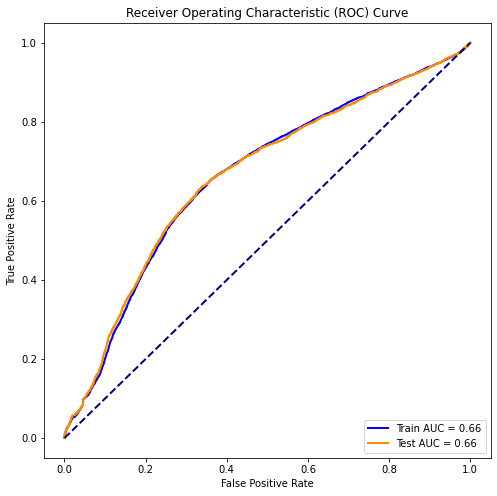

In [155]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Assuming you have calculated y_train_proba for the training set

# Calculate the ROC curve and AUC for training set
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_train_proba[:, 1], pos_label=1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Plot the ROC curve for training set
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train AUC = {roc_auc_train:.2f}')

# Assuming you have calculated y_test_proba for the testing set

# Calculate the ROC curve and AUC for testing set
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_test_proba[:, 1], pos_label=1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

# Plot the ROC curve for testing set
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test AUC = {roc_auc_test:.2f}')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

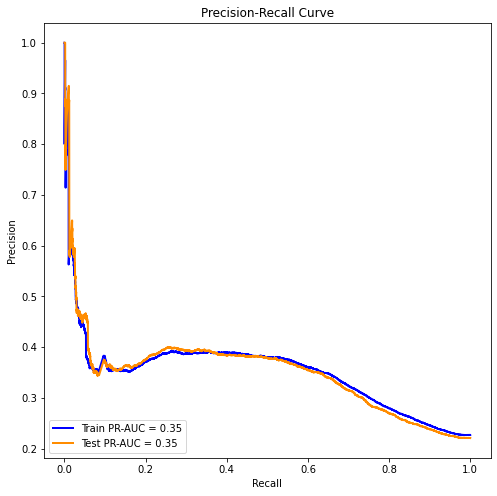

In [156]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Assuming you have calculated y_train_proba for the training set

# Calculate precision-recall curve and AUC for training set
precision_train, recall_train, _ = metrics.precision_recall_curve(y_train, y_train_proba[:, 1], pos_label=1)
pr_auc_train = metrics.auc(recall_train, precision_train)

# Plot the precision-recall curve for training set
plt.figure(figsize=(8, 8))
plt.plot(recall_train, precision_train, color='blue', lw=2, label=f'Train PR-AUC = {pr_auc_train:.2f}')

# Assuming you have calculated y_test_proba for the testing set

# Calculate precision-recall curve and AUC for testing set
precision_test, recall_test, _ = metrics.precision_recall_curve(y_test, y_test_proba[:, 1], pos_label=1)
pr_auc_test = metrics.auc(recall_test, precision_test)

# Plot the precision-recall curve for testing set
plt.plot(recall_test, precision_test, color='darkorange', lw=2, label=f'Test PR-AUC = {pr_auc_test:.2f}')

# Set labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

# Show the plot
plt.show()

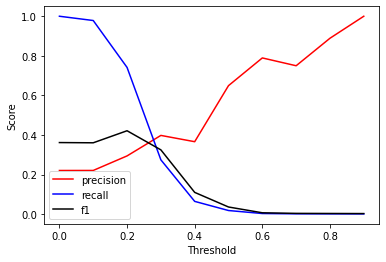

In [157]:
from sklearn.metrics import precision_score, recall_score, f1_score

# thresholds = np.linspace(0, 1, 10)
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
precisions = []
recalls = []
f1s = []

for threshold in thresholds:
    y_test_predic = (y_test_proba[:, 1] > threshold).astype(int)
    
    # Calculate precision, recall, and f1 for class 'Match' being 1 without averaging
    precisions.append(precision_score(y_test, y_test_predic, labels=[1], average=None)[0])
    recalls.append(recall_score(y_test, y_test_predic, labels=[1], average=None)[0])
    f1s.append(f1_score(y_test, y_test_predic, labels=[1], average=None)[0])

plt.plot(thresholds, precisions, color="red", label="precision")
plt.plot(thresholds, recalls, color="blue", label="recall")
plt.plot(thresholds, f1s, color="black", label="f1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [158]:
import numpy as np

# Find the index where recall is closest to 0.4
recall_target = 0.4
index_closest_recall = np.argmin(np.abs(np.array(recalls) - recall_target))

# Get the corresponding precision, recall, and f1 at that index
precision_at_target_recall = precisions[index_closest_recall]
recall_at_target_recall = recalls[index_closest_recall]
f1_at_target_recall = f1s[index_closest_recall]
threshold_at_target_recall = thresholds[index_closest_recall]

print(f'Precision at Recall = {recall_target:.2f}: {precision_at_target_recall:.2f}')
print(f'Recall at Recall = {recall_target:.2f}: {recall_at_target_recall:.2f}')
print(f'F1 Score at Recall = {recall_target:.2f}: {f1_at_target_recall:.2f}')
print(f'Threshold at Recall = {recall_target:.2f}: {threshold_at_target_recall:.2f}')

Precision at Recall = 0.40: 0.40
Recall at Recall = 0.40: 0.27
F1 Score at Recall = 0.40: 0.33
Threshold at Recall = 0.40: 0.30


In [225]:
y_train_predic = (y_train_proba[:, 1] > 0.30).astype(int)
    
# Calculate precision, recall, and f1 for class 'Match' being 1 without averaging
precision_train = precision_score(y_train, y_train_predic, labels=[1], average=None)[0]
recall_train = recall_score(y_train, y_train_predic, labels=[1], average=None)[0]
f1_train = f1_score(y_train, y_train_predic, labels=[1], average=None)[0]
# Print the results
print(f'Training Precision at Threshold = 0.3: {precision_train:.2f}')
print(f'Training Recall at Threshold = 0.3: {recall_train:.2f}')
print(f'Training F1 Score at Threshold = 0.3: {f1_train:.2f}')

Training Precision at Threshold = 0.3: 0.39
Training Recall at Threshold = 0.3: 0.27
Training F1 Score at Threshold = 0.3: 0.32


## 5.2 Decision Tree

### 5.2.1 Delete BOROUGH, ZIP CODE, Latitude and Longitude

In [226]:
from sklearn.tree import DecisionTreeClassifier

features = ['GROSS SQUARE FEET', 'SALE PRICE', 'Building Age', 'Month', 'Day', 'Weekday', 'Price per Square Feet','Distance']
target = 'Match'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

steps = [('Rescale', StandardScaler()),
         ('tree', DecisionTreeClassifier(random_state=42))]
tree_model = Pipeline(steps)

tree_model.fit(X_train, y_train)

y_train_pred = tree_model.predict(X_train)
y_test_pred = tree_model.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56329
           1       1.00      1.00      1.00     16557

    accuracy                           1.00     72886
   macro avg       1.00      1.00      1.00     72886
weighted avg       1.00      1.00      1.00     72886

              precision    recall  f1-score   support

           0       0.90      0.88      0.89     14194
           1       0.61      0.64      0.62      4028

    accuracy                           0.83     18222
   macro avg       0.75      0.76      0.76     18222
weighted avg       0.83      0.83      0.83     18222



In [227]:
y_train_proba = tree_model.predict_proba(X_train)
y_test_proba = tree_model.predict_proba(X_test)

print(roc_auc_score(y_train, y_train_proba[:, 1]))
print(roc_auc_score(y_test, y_test_proba[:, 1]))

0.9999997351601928
0.7621325058814031


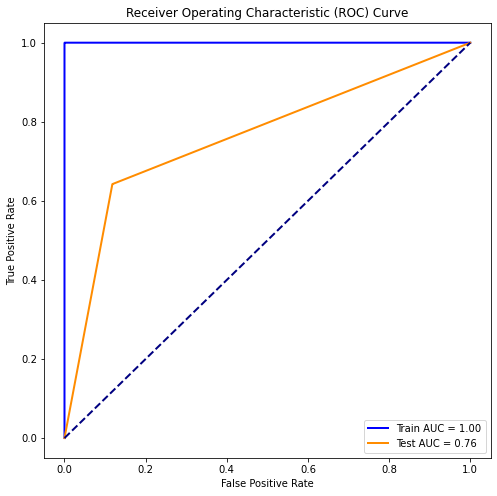

In [161]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Assuming you have calculated y_train_proba for the training set

# Calculate the ROC curve and AUC for training set
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_train_proba[:, 1], pos_label=1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Plot the ROC curve for training set
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train AUC = {roc_auc_train:.2f}')

# Assuming you have calculated y_test_proba for the testing set

# Calculate the ROC curve and AUC for testing set
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_test_proba[:, 1], pos_label=1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

# Plot the ROC curve for testing set
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test AUC = {roc_auc_test:.2f}')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

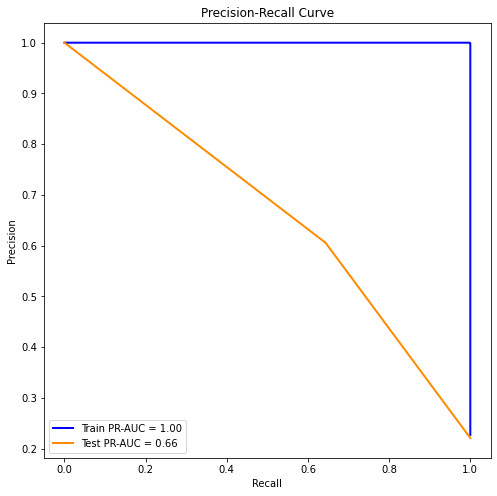

In [162]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Assuming you have calculated y_train_proba for the training set

# Calculate precision-recall curve and AUC for training set
precision_train, recall_train, _ = metrics.precision_recall_curve(y_train, y_train_proba[:, 1], pos_label=1)
pr_auc_train = metrics.auc(recall_train, precision_train)

# Plot the precision-recall curve for training set
plt.figure(figsize=(8, 8))
plt.plot(recall_train, precision_train, color='blue', lw=2, label=f'Train PR-AUC = {pr_auc_train:.2f}')

# Assuming you have calculated y_test_proba for the testing set

# Calculate precision-recall curve and AUC for testing set
precision_test, recall_test, _ = metrics.precision_recall_curve(y_test, y_test_proba[:, 1], pos_label=1)
pr_auc_test = metrics.auc(recall_test, precision_test)

# Plot the precision-recall curve for testing set
plt.plot(recall_test, precision_test, color='darkorange', lw=2, label=f'Test PR-AUC = {pr_auc_test:.2f}')

# Set labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

# Show the plot
plt.show()

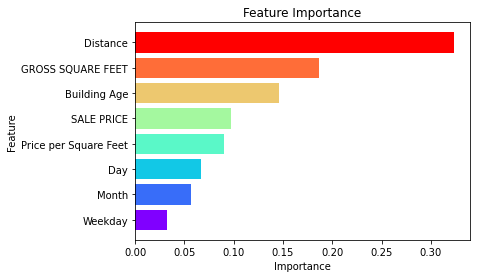

In [202]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have 'importances' and 'feature_names' defined
importances = tree_model.steps[1][1].feature_importances_
feature_names = X_train.columns

# Sort feature importances and corresponding feature names
sorted_indices = np.argsort(importances)  # Leave the order as is (lowest to highest)
sorted_importances = importances[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Set a colorful colormap ('rainbow')
colors = plt.cm.rainbow(np.linspace(0, 1, len(importances)))

# Create a horizontal bar plot with colorful bars
plt.barh(range(len(importances)), sorted_importances, color=colors, align="center")
plt.yticks(range(len(importances)), sorted_feature_names)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [205]:
importances = tree_model.steps[1][1].feature_importances_

# Get the indices that would sort the importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Sort the importances and feature names accordingly
sorted_importances = importances[sorted_indices]

# Optionally, you can get the feature names if available
feature_names = tree_model.steps[0][1].get_feature_names_out()

# Print or use the sorted importances and feature names as needed
print(sorted_importances)
print(feature_names[sorted_indices])

[0.32347923 0.18681814 0.14604063 0.09776977 0.09014267 0.06653616
 0.05648703 0.03272638]
['Distance' 'GROSS SQUARE FEET' 'Building Age' 'SALE PRICE'
 'Price per Square Feet' 'Day' 'Month' 'Weekday']


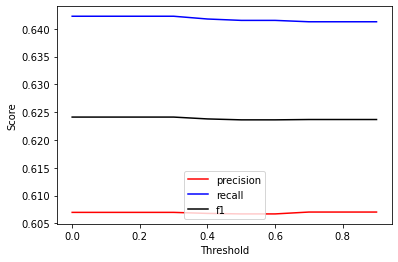

In [164]:
from sklearn.metrics import precision_score, recall_score, f1_score

# thresholds = np.linspace(0, 1, 10)
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
precisions = []
recalls = []
f1s = []

for threshold in thresholds:
    y_test_predic = (y_test_proba[:, 1] > threshold).astype(int)
    
    # Calculate precision, recall, and f1 for class 'Match' being 1 without averaging
    precisions.append(precision_score(y_test, y_test_predic, labels=[1], average=None)[0])
    recalls.append(recall_score(y_test, y_test_predic, labels=[1], average=None)[0])
    f1s.append(f1_score(y_test, y_test_predic, labels=[1], average=None)[0])

plt.plot(thresholds, precisions, color="red", label="precision")
plt.plot(thresholds, recalls, color="blue", label="recall")
plt.plot(thresholds, f1s, color="black", label="f1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

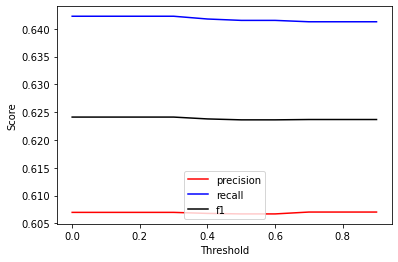

Threshold that maximizes precision: 0.70
Max Precision: 0.61
Corresponding Recall: 0.64
Corresponding F1 Score: 0.62


In [196]:
from sklearn.metrics import precision_score, recall_score, f1_score

# thresholds = np.linspace(0, 1, 10)
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
precisions = []
recalls = []
f1s = []

for threshold in thresholds:
    y_test_predic = (y_test_proba[:, 1] > threshold).astype(int)
    
    # Calculate precision, recall, and f1 for class 'Match' being 1 without averaging
    precisions.append(precision_score(y_test, y_test_predic, labels=[1], average=None)[0])
    recalls.append(recall_score(y_test, y_test_predic, labels=[1], average=None)[0])
    f1s.append(f1_score(y_test, y_test_predic, labels=[1], average=None)[0])

# Find the threshold that maximizes precision
max_precision_index = np.argmax(precisions)
max_precision_threshold = thresholds[max_precision_index]
max_precision_value = precisions[max_precision_index]
corresponding_recall = recalls[max_precision_index]
corresponding_f1 = f1s[max_precision_index]

plt.plot(thresholds, precisions, color="red", label="precision")
plt.plot(thresholds, recalls, color="blue", label="recall")
plt.plot(thresholds, f1s, color="black", label="f1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

print(f'Threshold that maximizes precision: {max_precision_threshold:.2f}')
print(f'Max Precision: {max_precision_value:.2f}')
print(f'Corresponding Recall: {corresponding_recall:.2f}')
print(f'Corresponding F1 Score: {corresponding_f1:.2f}')

In [228]:
y_train_predic = (y_train_proba[:, 1] > 0.70).astype(int)
    
# Calculate precision, recall, and f1 for class 'Match' being 1 without averaging
precision_train = precision_score(y_train, y_train_predic, labels=[1], average=None)[0]
recall_train = recall_score(y_train, y_train_predic, labels=[1], average=None)[0]
f1_train = f1_score(y_train, y_train_predic, labels=[1], average=None)[0]
# Print the results
print(f'Training Precision at Threshold = 0.70: {precision_train:.2f}')
print(f'Training Recall at Threshold = 0.70: {recall_train:.2f}')
print(f'Training F1 Score at Threshold = 0.70: {f1_train:.2f}')

Training Precision at Threshold = 0.70: 1.00
Training Recall at Threshold = 0.70: 1.00
Training F1 Score at Threshold = 0.70: 1.00


### 5.2.2 Using all features

In [229]:
features = ['BOROUGH', 'ZIP CODE', 'GROSS SQUARE FEET', 'SALE PRICE', 'Latitude', 'Longitude', 'Month', 'Day', 'Weekday', 'Building Age', 'Price per Square Feet', 'Distance']
target = 'Match'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

steps = [('Rescale', StandardScaler()),
         ('tree', DecisionTreeClassifier(random_state=42))]
tree_model = Pipeline(steps)

tree_model.fit(X_train, y_train)

y_train_pred = tree_model.predict(X_train)
y_test_pred = tree_model.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56329
           1       1.00      1.00      1.00     16557

    accuracy                           1.00     72886
   macro avg       1.00      1.00      1.00     72886
weighted avg       1.00      1.00      1.00     72886

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     14194
           1       0.68      0.70      0.69      4028

    accuracy                           0.86     18222
   macro avg       0.80      0.81      0.80     18222
weighted avg       0.86      0.86      0.86     18222



In [230]:
y_train_proba = tree_model.predict_proba(X_train)
y_test_proba = tree_model.predict_proba(X_test)

print(roc_auc_score(y_train, y_train_proba[:, 1]))
print(roc_auc_score(y_test, y_test_proba[:, 1]))

0.9999997351601928
0.8053820085525039


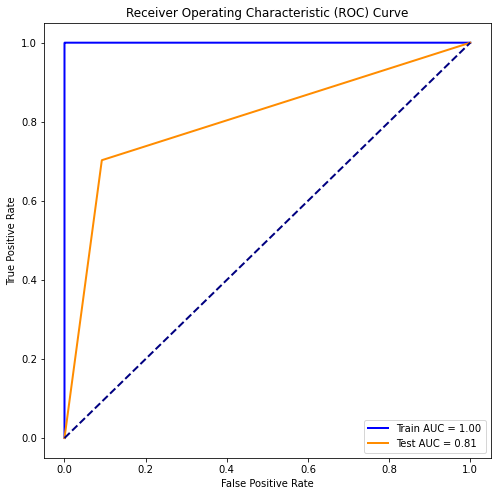

In [168]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Assuming you have calculated y_train_proba for the training set

# Calculate the ROC curve and AUC for training set
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_train_proba[:, 1], pos_label=1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Plot the ROC curve for training set
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train AUC = {roc_auc_train:.2f}')

# Assuming you have calculated y_test_proba for the testing set

# Calculate the ROC curve and AUC for testing set
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_test_proba[:, 1], pos_label=1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

# Plot the ROC curve for testing set
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test AUC = {roc_auc_test:.2f}')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

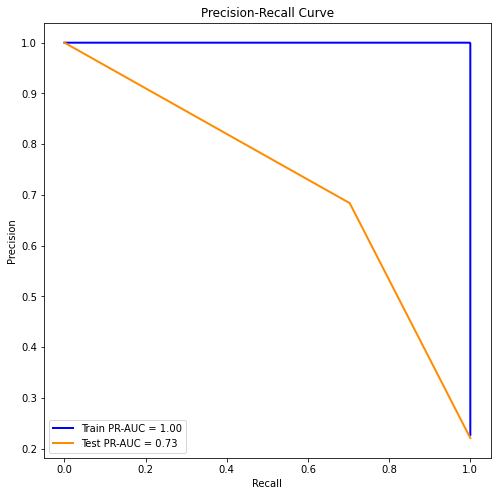

In [169]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Assuming you have calculated y_train_proba for the training set

# Calculate precision-recall curve and AUC for training set
precision_train, recall_train, _ = metrics.precision_recall_curve(y_train, y_train_proba[:, 1], pos_label=1)
pr_auc_train = metrics.auc(recall_train, precision_train)

# Plot the precision-recall curve for training set
plt.figure(figsize=(8, 8))
plt.plot(recall_train, precision_train, color='blue', lw=2, label=f'Train PR-AUC = {pr_auc_train:.2f}')

# Assuming you have calculated y_test_proba for the testing set

# Calculate precision-recall curve and AUC for testing set
precision_test, recall_test, _ = metrics.precision_recall_curve(y_test, y_test_proba[:, 1], pos_label=1)
pr_auc_test = metrics.auc(recall_test, precision_test)

# Plot the precision-recall curve for testing set
plt.plot(recall_test, precision_test, color='darkorange', lw=2, label=f'Test PR-AUC = {pr_auc_test:.2f}')

# Set labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

# Show the plot
plt.show()

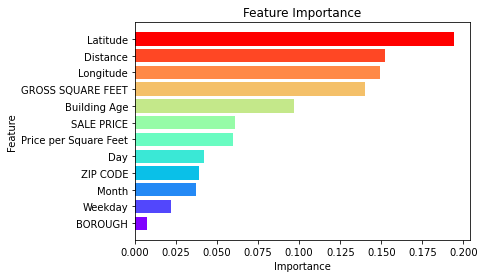

In [170]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have 'importances' and 'feature_names' defined
importances = tree_model.steps[1][1].feature_importances_
feature_names = X_train.columns

# Sort feature importances and corresponding feature names
sorted_indices = np.argsort(importances)  # Leave the order as is (lowest to highest)
sorted_importances = importances[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Set a colorful colormap ('rainbow')
colors = plt.cm.rainbow(np.linspace(0, 1, len(importances)))

# Create a horizontal bar plot with colorful bars
plt.barh(range(len(importances)), sorted_importances, color=colors, align="center")
plt.yticks(range(len(importances)), sorted_feature_names)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [207]:
importances = tree_model.steps[1][1].feature_importances_

# Get the indices that would sort the importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Sort the importances and feature names accordingly
sorted_importances = importances[sorted_indices]

# Optionally, you can get the feature names if available
feature_names = tree_model.steps[0][1].get_feature_names_out()

# Print or use the sorted importances and feature names as needed
print(sorted_importances)
print(feature_names[sorted_indices])

[0.1942535  0.1524524  0.14942849 0.14017993 0.09677429 0.06079383
 0.05979698 0.04168673 0.03910346 0.036837   0.02158233 0.00711105]
['Latitude' 'Distance' 'Longitude' 'GROSS SQUARE FEET' 'Building Age'
 'SALE PRICE' 'Price per Square Feet' 'Day' 'ZIP CODE' 'Month' 'Weekday'
 'BOROUGH']


* The performance is better using all features.

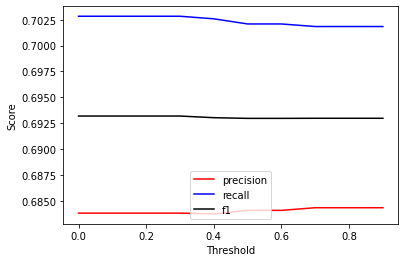

In [171]:
from sklearn.metrics import precision_score, recall_score, f1_score

# thresholds = np.linspace(0, 1, 10)
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
precisions = []
recalls = []
f1s = []

for threshold in thresholds:
    y_test_predic = (y_test_proba[:, 1] > threshold).astype(int)
    
    # Calculate precision, recall, and f1 for class 'Match' being 1 without averaging
    precisions.append(precision_score(y_test, y_test_predic, labels=[1], average=None)[0])
    recalls.append(recall_score(y_test, y_test_predic, labels=[1], average=None)[0])
    f1s.append(f1_score(y_test, y_test_predic, labels=[1], average=None)[0])

plt.plot(thresholds, precisions, color="red", label="precision")
plt.plot(thresholds, recalls, color="blue", label="recall")
plt.plot(thresholds, f1s, color="black", label="f1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

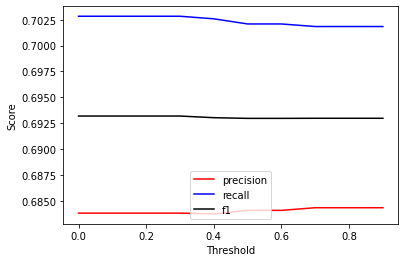

Threshold that maximizes precision: 0.70
Max Precision: 0.68
Corresponding Recall: 0.70
Corresponding F1 Score: 0.69


In [199]:
from sklearn.metrics import precision_score, recall_score, f1_score

# thresholds = np.linspace(0, 1, 10)
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
precisions = []
recalls = []
f1s = []

for threshold in thresholds:
    y_test_predic = (y_test_proba[:, 1] > threshold).astype(int)
    
    # Calculate precision, recall, and f1 for class 'Match' being 1 without averaging
    precisions.append(precision_score(y_test, y_test_predic, labels=[1], average=None)[0])
    recalls.append(recall_score(y_test, y_test_predic, labels=[1], average=None)[0])
    f1s.append(f1_score(y_test, y_test_predic, labels=[1], average=None)[0])

# Find the threshold that maximizes precision
max_precision_index = np.argmax(precisions)
max_precision_threshold = thresholds[max_precision_index]
max_precision_value = precisions[max_precision_index]
corresponding_recall = recalls[max_precision_index]
corresponding_f1 = f1s[max_precision_index]

plt.plot(thresholds, precisions, color="red", label="precision")
plt.plot(thresholds, recalls, color="blue", label="recall")
plt.plot(thresholds, f1s, color="black", label="f1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

print(f'Threshold that maximizes precision: {max_precision_threshold:.2f}')
print(f'Max Precision: {max_precision_value:.2f}')
print(f'Corresponding Recall: {corresponding_recall:.2f}')
print(f'Corresponding F1 Score: {corresponding_f1:.2f}')

In [231]:
y_train_predic = (y_train_proba[:, 1] > 0.70).astype(int)
    
# Calculate precision, recall, and f1 for class 'Match' being 1 without averaging
precision_train = precision_score(y_train, y_train_predic, labels=[1], average=None)[0]
recall_train = recall_score(y_train, y_train_predic, labels=[1], average=None)[0]
f1_train = f1_score(y_train, y_train_predic, labels=[1], average=None)[0]
# Print the results
print(f'Training Precision at Threshold = 0.70: {precision_train:.2f}')
print(f'Training Recall at Threshold = 0.70: {recall_train:.2f}')
print(f'Training F1 Score at Threshold = 0.70: {f1_train:.2f}')

Training Precision at Threshold = 0.70: 1.00
Training Recall at Threshold = 0.70: 1.00
Training F1 Score at Threshold = 0.70: 1.00


## 5.3 Random Forest

In [247]:
from sklearn.ensemble import RandomForestClassifier

features = ['BOROUGH', 'ZIP CODE', 'GROSS SQUARE FEET', 'SALE PRICE', 'Latitude', 'Longitude', 'Month', 'Day', 'Weekday', 'Building Age', 'Price per Square Feet', 'Distance']
target = 'Match'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

steps = [('Rescale', StandardScaler()),
         ('rf', RandomForestClassifier(random_state=42))]
rf_model = Pipeline(steps)

rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56329
           1       1.00      1.00      1.00     16557

    accuracy                           1.00     72886
   macro avg       1.00      1.00      1.00     72886
weighted avg       1.00      1.00      1.00     72886

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     14194
           1       0.87      0.69      0.77      4028

    accuracy                           0.91     18222
   macro avg       0.89      0.83      0.86     18222
weighted avg       0.91      0.91      0.91     18222



In [249]:
rf_model[1][1].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1273642419,
 'splitter': 'best'}

In [248]:
rf_model.named_steps['rf'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [233]:
y_train_proba = rf_model.predict_proba(X_train)
y_test_proba = rf_model.predict_proba(X_test)

print(roc_auc_score(y_train, y_train_proba[:, 1]))
print(roc_auc_score(y_test, y_test_proba[:, 1]))

0.9999956955489627
0.9276514133347811


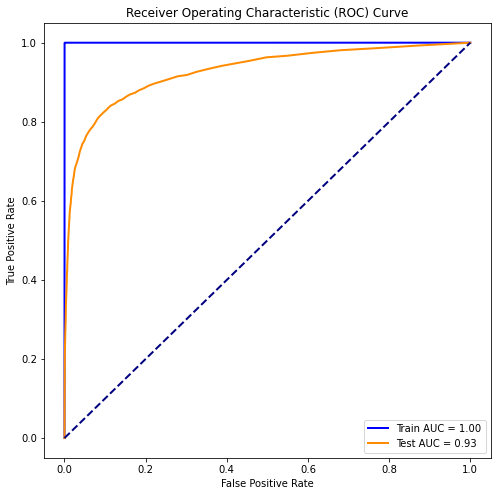

In [175]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Assuming you have calculated y_train_proba for the training set

# Calculate the ROC curve and AUC for training set
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_train_proba[:, 1], pos_label=1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Plot the ROC curve for training set
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train AUC = {roc_auc_train:.2f}')

# Assuming you have calculated y_test_proba for the testing set

# Calculate the ROC curve and AUC for testing set
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_test_proba[:, 1], pos_label=1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

# Plot the ROC curve for testing set
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test AUC = {roc_auc_test:.2f}')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

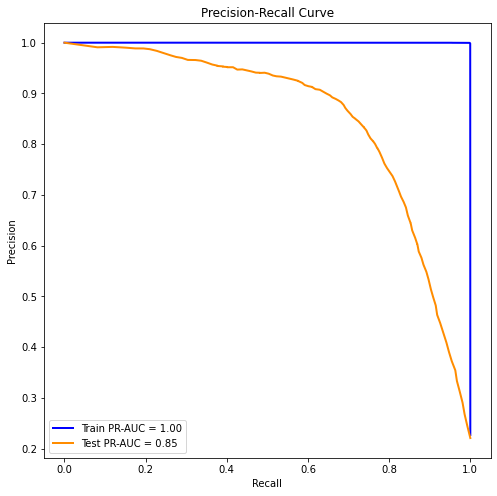

In [176]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Assuming you have calculated y_train_proba for the training set

# Calculate precision-recall curve and AUC for training set
precision_train, recall_train, _ = metrics.precision_recall_curve(y_train, y_train_proba[:, 1], pos_label=1)
pr_auc_train = metrics.auc(recall_train, precision_train)

# Plot the precision-recall curve for training set
plt.figure(figsize=(8, 8))
plt.plot(recall_train, precision_train, color='blue', lw=2, label=f'Train PR-AUC = {pr_auc_train:.2f}')

# Assuming you have calculated y_test_proba for the testing set

# Calculate precision-recall curve and AUC for testing set
precision_test, recall_test, _ = metrics.precision_recall_curve(y_test, y_test_proba[:, 1], pos_label=1)
pr_auc_test = metrics.auc(recall_test, precision_test)

# Plot the precision-recall curve for testing set
plt.plot(recall_test, precision_test, color='darkorange', lw=2, label=f'Test PR-AUC = {pr_auc_test:.2f}')

# Set labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

# Show the plot
plt.show()

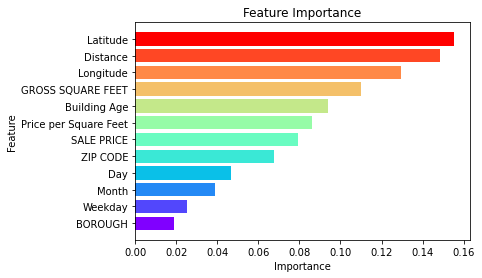

In [177]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have 'importances' and 'feature_names' defined
importances = rf_model.steps[1][1].feature_importances_
feature_names = X_train.columns

# Sort feature importances and corresponding feature names
sorted_indices = np.argsort(importances)  # Leave the order as is (lowest to highest)
sorted_importances = importances[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Set a colorful colormap ('rainbow')
colors = plt.cm.rainbow(np.linspace(0, 1, len(importances)))

# Create a horizontal bar plot with colorful bars
plt.barh(range(len(importances)), sorted_importances, color=colors, align="center")
plt.yticks(range(len(importances)), sorted_feature_names)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [209]:
importances = rf_model.steps[1][1].feature_importances_

# Get the indices that would sort the importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Sort the importances and feature names accordingly
sorted_importances = importances[sorted_indices]

# Optionally, you can get the feature names if available
feature_names = rf_model.steps[0][1].get_feature_names_out()

# Print or use the sorted importances and feature names as needed
print(sorted_importances)
print(feature_names[sorted_indices])

[0.15524915 0.14839981 0.12958344 0.10994493 0.09394241 0.08626708
 0.079243   0.06766484 0.04655304 0.03913789 0.02507103 0.01894338]
['Latitude' 'Distance' 'Longitude' 'GROSS SQUARE FEET' 'Building Age'
 'Price per Square Feet' 'SALE PRICE' 'ZIP CODE' 'Day' 'Month' 'Weekday'
 'BOROUGH']


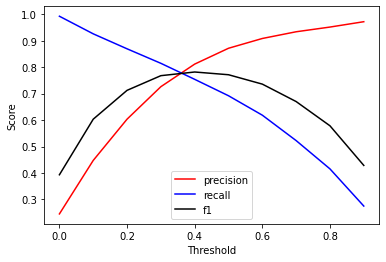

In [178]:
from sklearn.metrics import precision_score, recall_score, f1_score

# thresholds = np.linspace(0, 1, 10)
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
precisions = []
recalls = []
f1s = []

for threshold in thresholds:
    y_test_predic = (y_test_proba[:, 1] > threshold).astype(int)
    
    # Calculate precision, recall, and f1 for class 'Match' being 1 without averaging
    precisions.append(precision_score(y_test, y_test_predic, labels=[1], average=None)[0])
    recalls.append(recall_score(y_test, y_test_predic, labels=[1], average=None)[0])
    f1s.append(f1_score(y_test, y_test_predic, labels=[1], average=None)[0])

plt.plot(thresholds, precisions, color="red", label="precision")
plt.plot(thresholds, recalls, color="blue", label="recall")
plt.plot(thresholds, f1s, color="black", label="f1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [179]:
import numpy as np

# Find the index where recall is closest to 0.4
recall_target = 0.4
index_closest_recall = np.argmin(np.abs(np.array(recalls) - recall_target))

# Get the corresponding precision, recall, and f1 at that index
precision_at_target_recall = precisions[index_closest_recall]
recall_at_target_recall = recalls[index_closest_recall]
f1_at_target_recall = f1s[index_closest_recall]
threshold_at_target_recall = thresholds[index_closest_recall]

print(f'Precision at Recall = {recall_target:.2f}: {precision_at_target_recall:.2f}')
print(f'Recall at Recall = {recall_target:.2f}: {recall_at_target_recall:.2f}')
print(f'F1 Score at Recall = {recall_target:.2f}: {f1_at_target_recall:.2f}')
print(f'Threshold at Recall = {recall_target:.2f}: {threshold_at_target_recall:.2f}')

Precision at Recall = 0.40: 0.95
Recall at Recall = 0.40: 0.42
F1 Score at Recall = 0.40: 0.58
Threshold at Recall = 0.40: 0.80


In [234]:
y_train_predic = (y_train_proba[:, 1] > 0.80).astype(int)
    
# Calculate precision, recall, and f1 for class 'Match' being 1 without averaging
precision_train = precision_score(y_train, y_train_predic, labels=[1], average=None)[0]
recall_train = recall_score(y_train, y_train_predic, labels=[1], average=None)[0]
f1_train = f1_score(y_train, y_train_predic, labels=[1], average=None)[0]
# Print the results
print(f'Training Precision at Threshold = 0.80: {precision_train:.2f}')
print(f'Training Recall at Threshold = 0.80: {recall_train:.2f}')
print(f'Training F1 Score at Threshold = 0.80: {f1_train:.2f}')

Training Precision at Threshold = 0.80: 1.00
Training Recall at Threshold = 0.80: 0.72
Training F1 Score at Threshold = 0.80: 0.84


## 5.4 Gradient Boosting

In [235]:
from sklearn.ensemble import GradientBoostingClassifier

features = ['BOROUGH', 'ZIP CODE', 'GROSS SQUARE FEET', 'SALE PRICE', 'Latitude', 'Longitude', 'Month', 'Day', 'Weekday', 'Building Age', 'Price per Square Feet', 'Distance']
target = 'Match'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

steps = [('Rescale', StandardScaler()),
         ('gb', GradientBoostingClassifier(random_state=42))]
gb_model = Pipeline(steps)

gb_model.fit(X_train, y_train)

y_train_pred = gb_model.predict(X_train)
y_test_pred = gb_model.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90     56329
           1       0.79      0.38      0.51     16557

    accuracy                           0.84     72886
   macro avg       0.82      0.67      0.71     72886
weighted avg       0.83      0.84      0.81     72886

              precision    recall  f1-score   support

           0       0.84      0.97      0.90     14194
           1       0.77      0.36      0.49      4028

    accuracy                           0.83     18222
   macro avg       0.81      0.66      0.70     18222
weighted avg       0.83      0.83      0.81     18222



In [236]:
y_train_proba = gb_model.predict_proba(X_train)
y_test_proba = gb_model.predict_proba(X_test)

print(roc_auc_score(y_train, y_train_proba[:, 1]))
print(roc_auc_score(y_test, y_test_proba[:, 1]))

0.8516820329457011
0.8464496149190415


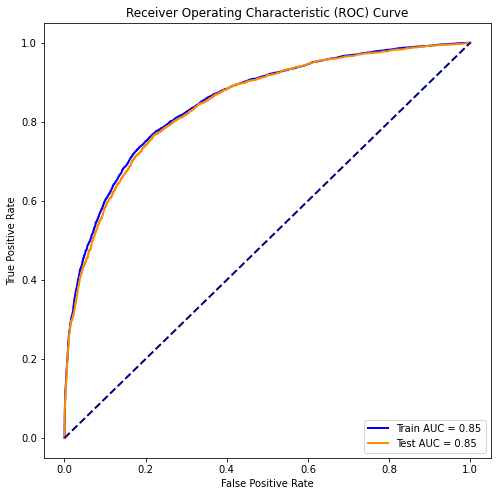

In [182]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Assuming you have calculated y_train_proba for the training set

# Calculate the ROC curve and AUC for training set
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_train_proba[:, 1], pos_label=1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Plot the ROC curve for training set
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train AUC = {roc_auc_train:.2f}')

# Assuming you have calculated y_test_proba for the testing set

# Calculate the ROC curve and AUC for testing set
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_test_proba[:, 1], pos_label=1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

# Plot the ROC curve for testing set
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test AUC = {roc_auc_test:.2f}')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

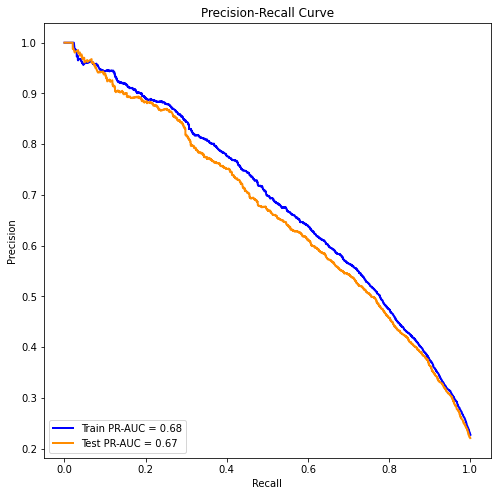

In [183]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Assuming you have calculated y_train_proba for the training set

# Calculate precision-recall curve and AUC for training set
precision_train, recall_train, _ = metrics.precision_recall_curve(y_train, y_train_proba[:, 1], pos_label=1)
pr_auc_train = metrics.auc(recall_train, precision_train)

# Plot the precision-recall curve for training set
plt.figure(figsize=(8, 8))
plt.plot(recall_train, precision_train, color='blue', lw=2, label=f'Train PR-AUC = {pr_auc_train:.2f}')

# Assuming you have calculated y_test_proba for the testing set

# Calculate precision-recall curve and AUC for testing set
precision_test, recall_test, _ = metrics.precision_recall_curve(y_test, y_test_proba[:, 1], pos_label=1)
pr_auc_test = metrics.auc(recall_test, precision_test)

# Plot the precision-recall curve for testing set
plt.plot(recall_test, precision_test, color='darkorange', lw=2, label=f'Test PR-AUC = {pr_auc_test:.2f}')

# Set labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

# Show the plot
plt.show()

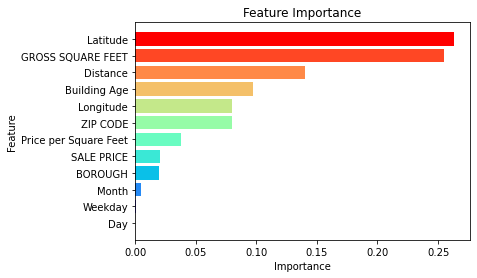

In [184]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have 'importances' and 'feature_names' defined
importances = gb_model.steps[1][1].feature_importances_
feature_names = X_train.columns

# Sort feature importances and corresponding feature names
sorted_indices = np.argsort(importances)  # Leave the order as is (lowest to highest)
sorted_importances = importances[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Set a colorful colormap ('rainbow')
colors = plt.cm.rainbow(np.linspace(0, 1, len(importances)))

# Create a horizontal bar plot with colorful bars
plt.barh(range(len(importances)), sorted_importances, color=colors, align="center")
plt.yticks(range(len(importances)), sorted_feature_names)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [211]:
importances = gb_model.steps[1][1].feature_importances_

# Get the indices that would sort the importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Sort the importances and feature names accordingly
sorted_importances = importances[sorted_indices]

# Optionally, you can get the feature names if available
feature_names = gb_model.steps[0][1].get_feature_names_out()

# Print or use the sorted importances and feature names as needed
print(sorted_importances)
print(feature_names[sorted_indices])

[0.26306098 0.25522815 0.14035444 0.09708854 0.08030447 0.07998315
 0.03780519 0.02090173 0.02009768 0.00460479 0.00057088 0.        ]
['Latitude' 'GROSS SQUARE FEET' 'Distance' 'Building Age' 'Longitude'
 'ZIP CODE' 'Price per Square Feet' 'SALE PRICE' 'BOROUGH' 'Month'
 'Weekday' 'Day']


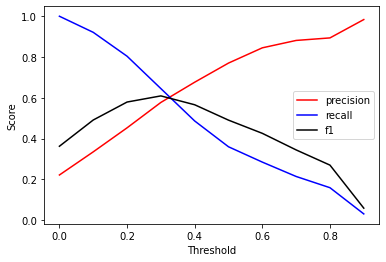

In [185]:
from sklearn.metrics import precision_score, recall_score, f1_score

# thresholds = np.linspace(0, 1, 10)
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
precisions = []
recalls = []
f1s = []

for threshold in thresholds:
    y_test_predic = (y_test_proba[:, 1] > threshold).astype(int)
    
    # Calculate precision, recall, and f1 for class 'Match' being 1 without averaging
    precisions.append(precision_score(y_test, y_test_predic, labels=[1], average=None)[0])
    recalls.append(recall_score(y_test, y_test_predic, labels=[1], average=None)[0])
    f1s.append(f1_score(y_test, y_test_predic, labels=[1], average=None)[0])

plt.plot(thresholds, precisions, color="red", label="precision")
plt.plot(thresholds, recalls, color="blue", label="recall")
plt.plot(thresholds, f1s, color="black", label="f1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [186]:
import numpy as np

# Find the index where recall is closest to 0.4
recall_target = 0.4
index_closest_recall = np.argmin(np.abs(np.array(recalls) - recall_target))

# Get the corresponding precision, recall, and f1 at that index
precision_at_target_recall = precisions[index_closest_recall]
recall_at_target_recall = recalls[index_closest_recall]
f1_at_target_recall = f1s[index_closest_recall]
threshold_at_target_recall = thresholds[index_closest_recall]

print(f'Precision at Recall = {recall_target:.2f}: {precision_at_target_recall:.2f}')
print(f'Recall at Recall = {recall_target:.2f}: {recall_at_target_recall:.2f}')
print(f'F1 Score at Recall = {recall_target:.2f}: {f1_at_target_recall:.2f}')
print(f'Threshold at Recall = {recall_target:.2f}: {threshold_at_target_recall:.2f}')

Precision at Recall = 0.40: 0.77
Recall at Recall = 0.40: 0.36
F1 Score at Recall = 0.40: 0.49
Threshold at Recall = 0.40: 0.50


In [237]:
y_train_predic = (y_train_proba[:, 1] > 0.50).astype(int)
    
# Calculate precision, recall, and f1 for class 'Match' being 1 without averaging
precision_train = precision_score(y_train, y_train_predic, labels=[1], average=None)[0]
recall_train = recall_score(y_train, y_train_predic, labels=[1], average=None)[0]
f1_train = f1_score(y_train, y_train_predic, labels=[1], average=None)[0]
# Print the results
print(f'Training Precision at Threshold = 0.50: {precision_train:.2f}')
print(f'Training Recall at Threshold = 0.50: {recall_train:.2f}')
print(f'Training F1 Score at Threshold = 0.50: {f1_train:.2f}')

Training Precision at Threshold = 0.50: 0.79
Training Recall at Threshold = 0.50: 0.38
Training F1 Score at Threshold = 0.50: 0.51


## 5.5 XGBoost

In [238]:
from xgboost import XGBClassifier

features = ['BOROUGH', 'ZIP CODE', 'GROSS SQUARE FEET', 'SALE PRICE', 'Latitude', 'Longitude', 'Month', 'Day', 'Weekday', 'Building Age', 'Price per Square Feet', 'Distance']
target = 'Match'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

steps = [('Rescale', StandardScaler()),
         ('xgb', XGBClassifier(random_state=42))]
xgb_model = Pipeline(steps)

xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     56329
           1       0.88      0.70      0.78     16557

    accuracy                           0.91     72886
   macro avg       0.90      0.83      0.86     72886
weighted avg       0.91      0.91      0.91     72886

              precision    recall  f1-score   support

           0       0.90      0.96      0.93     14194
           1       0.82      0.63      0.71      4028

    accuracy                           0.89     18222
   macro avg       0.86      0.79      0.82     18222
weighted avg       0.88      0.89      0.88     18222



In [239]:
y_train_proba = xgb_model.predict_proba(X_train)
y_test_proba = xgb_model.predict_proba(X_test)

print(roc_auc_score(y_train, y_train_proba[:, 1]))
print(roc_auc_score(y_test, y_test_proba[:, 1]))

0.9488603451478361
0.9105957029131994


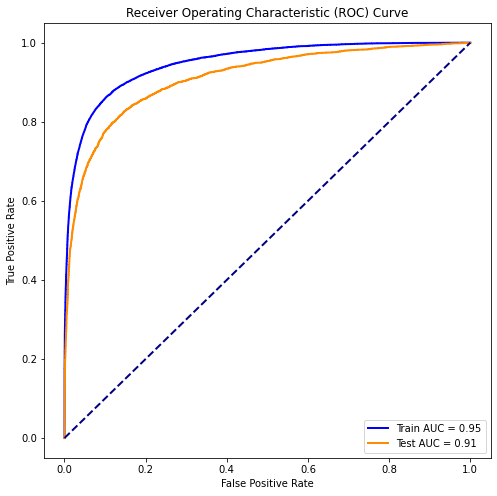

In [189]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Assuming you have calculated y_train_proba for the training set

# Calculate the ROC curve and AUC for training set
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_train_proba[:, 1], pos_label=1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Plot the ROC curve for training set
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train AUC = {roc_auc_train:.2f}')

# Assuming you have calculated y_test_proba for the testing set

# Calculate the ROC curve and AUC for testing set
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_test_proba[:, 1], pos_label=1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

# Plot the ROC curve for testing set
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test AUC = {roc_auc_test:.2f}')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

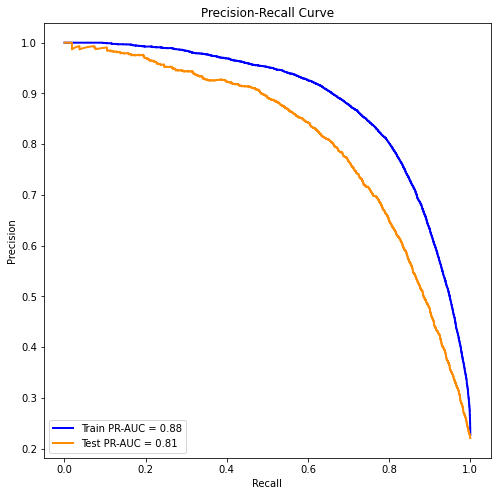

In [190]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Assuming you have calculated y_train_proba for the training set

# Calculate precision-recall curve and AUC for training set
precision_train, recall_train, _ = metrics.precision_recall_curve(y_train, y_train_proba[:, 1], pos_label=1)
pr_auc_train = metrics.auc(recall_train, precision_train)

# Plot the precision-recall curve for training set
plt.figure(figsize=(8, 8))
plt.plot(recall_train, precision_train, color='blue', lw=2, label=f'Train PR-AUC = {pr_auc_train:.2f}')

# Assuming you have calculated y_test_proba for the testing set

# Calculate precision-recall curve and AUC for testing set
precision_test, recall_test, _ = metrics.precision_recall_curve(y_test, y_test_proba[:, 1], pos_label=1)
pr_auc_test = metrics.auc(recall_test, precision_test)

# Plot the precision-recall curve for testing set
plt.plot(recall_test, precision_test, color='darkorange', lw=2, label=f'Test PR-AUC = {pr_auc_test:.2f}')

# Set labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

# Show the plot
plt.show()

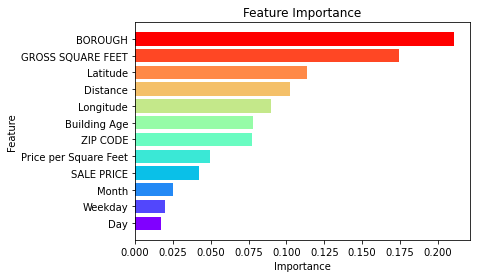

In [191]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have 'importances' and 'feature_names' defined
importances = xgb_model.steps[1][1].feature_importances_
feature_names = X_train.columns

# Sort feature importances and corresponding feature names
sorted_indices = np.argsort(importances)  # Leave the order as is (lowest to highest)
sorted_importances = importances[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Set a colorful colormap ('rainbow')
colors = plt.cm.rainbow(np.linspace(0, 1, len(importances)))

# Create a horizontal bar plot with colorful bars
plt.barh(range(len(importances)), sorted_importances, color=colors, align="center")
plt.yticks(range(len(importances)), sorted_feature_names)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [213]:
importances = xgb_model.steps[1][1].feature_importances_

# Get the indices that would sort the importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Sort the importances and feature names accordingly
sorted_importances = importances[sorted_indices]

# Optionally, you can get the feature names if available
feature_names = xgb_model.steps[0][1].get_feature_names_out()

# Print or use the sorted importances and feature names as needed
print(sorted_importances)
print(feature_names[sorted_indices])

[0.21064913 0.17460719 0.11347779 0.10210525 0.08989849 0.07812463
 0.07722975 0.04949671 0.04199038 0.02492959 0.02005186 0.01743925]
['BOROUGH' 'GROSS SQUARE FEET' 'Latitude' 'Distance' 'Longitude'
 'Building Age' 'ZIP CODE' 'Price per Square Feet' 'SALE PRICE' 'Month'
 'Weekday' 'Day']


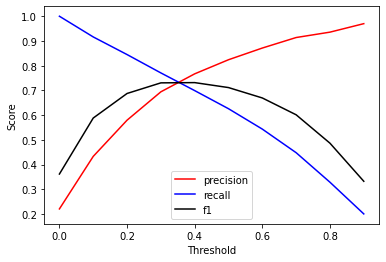

In [192]:
from sklearn.metrics import precision_score, recall_score, f1_score

# thresholds = np.linspace(0, 1, 10)
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
precisions = []
recalls = []
f1s = []

for threshold in thresholds:
    y_test_predic = (y_test_proba[:, 1] > threshold).astype(int)
    
    # Calculate precision, recall, and f1 for class 'Match' being 1 without averaging
    precisions.append(precision_score(y_test, y_test_predic, labels=[1], average=None)[0])
    recalls.append(recall_score(y_test, y_test_predic, labels=[1], average=None)[0])
    f1s.append(f1_score(y_test, y_test_predic, labels=[1], average=None)[0])

plt.plot(thresholds, precisions, color="red", label="precision")
plt.plot(thresholds, recalls, color="blue", label="recall")
plt.plot(thresholds, f1s, color="black", label="f1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [193]:
import numpy as np

# Find the index where recall is closest to 0.4
recall_target = 0.4
index_closest_recall = np.argmin(np.abs(np.array(recalls) - recall_target))

# Get the corresponding precision, recall, and f1 at that index
precision_at_target_recall = precisions[index_closest_recall]
recall_at_target_recall = recalls[index_closest_recall]
f1_at_target_recall = f1s[index_closest_recall]
threshold_at_target_recall = thresholds[index_closest_recall]

print(f'Precision at Recall = {recall_target:.2f}: {precision_at_target_recall:.2f}')
print(f'Recall at Recall = {recall_target:.2f}: {recall_at_target_recall:.2f}')
print(f'F1 Score at Recall = {recall_target:.2f}: {f1_at_target_recall:.2f}')
print(f'Threshold at Recall = {recall_target:.2f}: {threshold_at_target_recall:.2f}')

Precision at Recall = 0.40: 0.91
Recall at Recall = 0.40: 0.45
F1 Score at Recall = 0.40: 0.60
Threshold at Recall = 0.40: 0.70


In [240]:
y_train_predic = (y_train_proba[:, 1] > 0.70).astype(int)
    
# Calculate precision, recall, and f1 for class 'Match' being 1 without averaging
precision_train = precision_score(y_train, y_train_predic, labels=[1], average=None)[0]
recall_train = recall_score(y_train, y_train_predic, labels=[1], average=None)[0]
f1_train = f1_score(y_train, y_train_predic, labels=[1], average=None)[0]
# Print the results
print(f'Training Precision at Threshold = 0.70: {precision_train:.2f}')
print(f'Training Recall at Threshold = 0.70: {recall_train:.2f}')
print(f'Training F1 Score at Threshold = 0.70: {f1_train:.2f}')

Training Precision at Threshold = 0.70: 0.95
Training Recall at Threshold = 0.70: 0.50
Training F1 Score at Threshold = 0.70: 0.65
